# Disperser transmission study


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [135]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [136]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [137]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [138]:
from scipy import interpolate

In [139]:
import seaborn as sns

In [140]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure style

In [141]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [142]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [143]:
PATH_SPECTRACTOR='../../Spectractor'
PATH_SPECTRACTORSIM='../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../merra2'

In [144]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [145]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [146]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [147]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [148]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [149]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [150]:
home=os.getenv('HOME')

In [151]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [152]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [153]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [154]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [155]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [156]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [157]:
PATH_SPECTRACTORSIM

'../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [158]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')

In [159]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

## Selection of night

In [160]:
date="20170610"

In [161]:
idx_sel_subdir=11

In [162]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [163]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [164]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [165]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [166]:
wlshift.head()

,index,wlshift
0,135,-5.834064
1,139,-5.594220
2,140,-8.303469
3,141,8.186024
4,142,-4.141106


### path for spectra

In [167]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [168]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [169]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [170]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [171]:
sel_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-11T05:27:03.156,135,778,"13,2",24,"1,018","0,667",30,HD160617,RG715,Thor300,12450,"13,6",data_10jun17,reduc_20170610_135.fits
2017-06-11T05:28:25.696,136,778,"13,4",23,"1,019","0,667",30,HD160617,RG715,HoloPhP,12450,"16,9",data_10jun17,reduc_20170610_136.fits
2017-06-11T05:29:51.205,137,778,"13,4",23,"1,019","0,802",60,HD160617,RG715,HoloPhAg,12450,"12,5",data_10jun17,reduc_20170610_137.fits
2017-06-11T05:31:43.708,138,778,"13,3",23,"1,02","0,712",60,HD160617,RG715,HoloAmAg,12450,"15,9",data_10jun17,reduc_20170610_138.fits
2017-06-11T05:34:06.396,139,778,"13,5",23,"1,874","0,712",30,HD185975,RG715,Thor300,12450,"17,4",data_10jun17,reduc_20170610_139.fits


In [172]:
sel_obs.tail()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-11T10:18:34.256,299,778,12,23,"1,044","0,753",30,HD205905,RG715,Thor300,12450,"15,1",data_10jun17,reduc_20170610_299.fits
2017-06-11T10:19:56.704,300,778,"12,1",23,"1,046","0,753",30,HD205905,RG715,HoloPhP,12450,"15,8",data_10jun17,reduc_20170610_300.fits
2017-06-11T10:21:22.002,301,778,"12,1",23,"1,047","0,753",60,HD205905,RG715,HoloPhAg,12450,"12,8",data_10jun17,reduc_20170610_301.fits
2017-06-11T10:23:14.496,302,778,"12,1",23,"1,05","0,753",60,HD205905,RG715,HoloAmAg,12450,"15,3",data_10jun17,reduc_20170610_302.fits
2017-06-11T10:25:41.750,303,778,"12,1",23,"2,241","0,753",30,HD160617,RG715,Thor300,12450,17,data_10jun17,reduc_20170610_303.fits


### Quick view on the kind of sources

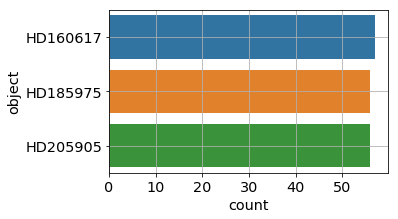

In [173]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

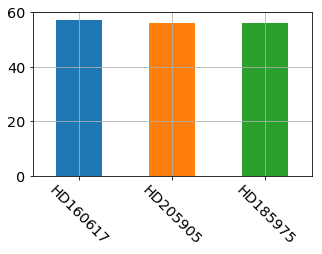

In [174]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectra

In [175]:
bad_obs_0=sel_obs.loc[sel_obs['index'].isin([57])]

In [176]:
bad_obs_0

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,


### Remove bad sources

- remove star **PNG336.3-05.6**

In [177]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6'])]
bad_indexes=bad_obs["index"]

In [178]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,


In [179]:
bad_indexes=bad_obs.loc[:,"index"]

In [180]:
bad_indexes.index

Index([], dtype='object', name=u'date')

In [181]:
bad_indexes.values

array([], dtype=int64)

### Concatenate bad obs

In [182]:
bad_obs=pd.concat([bad_obs,bad_obs_0])

In [183]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,


In [184]:
bad_obs.sort_values(by="index",inplace=True)

In [185]:
bad_indexes=bad_obs.loc[:,"index"]

In [186]:
bad_indexes.index

Index([], dtype='object', name=u'date')

In [187]:
bad_indexes.values

array([], dtype=int64)

- keep stars **HD111980**, **HD205905**

In [188]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD160617','HD185975','HD205905'])]

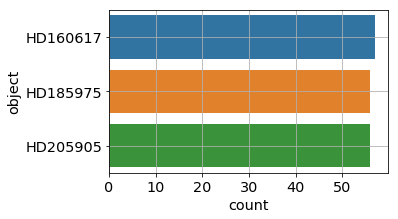

In [190]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

### Bad reconstructed spectra

In [191]:
bad_calib_indexes=np.array([136,137,138,148,149,150,160,161,162,172,173,174,184,185,186,196,197,198,208,209,210,
                           220,221,222,232,233,234,244,245,246,256,257,258,268,269,270,280,281,282,291,292,293,294])

## Remove bad indexes

In [192]:
file_toremove=[]
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_calib_indexes:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f) 

 remove  reduc_20170610_136_spectrum.fits
 remove  reduc_20170610_137_spectrum.fits
 remove  reduc_20170610_138_spectrum.fits
 remove  reduc_20170610_148_spectrum.fits
 remove  reduc_20170610_149_spectrum.fits
 remove  reduc_20170610_150_spectrum.fits
 remove  reduc_20170610_160_spectrum.fits
 remove  reduc_20170610_161_spectrum.fits
 remove  reduc_20170610_162_spectrum.fits
 remove  reduc_20170610_172_spectrum.fits
 remove  reduc_20170610_173_spectrum.fits
 remove  reduc_20170610_174_spectrum.fits
 remove  reduc_20170610_184_spectrum.fits
 remove  reduc_20170610_185_spectrum.fits
 remove  reduc_20170610_186_spectrum.fits
 remove  reduc_20170610_196_spectrum.fits
 remove  reduc_20170610_197_spectrum.fits
 remove  reduc_20170610_198_spectrum.fits
 remove  reduc_20170610_208_spectrum.fits
 remove  reduc_20170610_209_spectrum.fits
 remove  reduc_20170610_210_spectrum.fits
 remove  reduc_20170610_220_spectrum.fits
 remove  reduc_20170610_221_spectrum.fits
 remove  reduc_20170610_222_spectr

#### Make a list of the object names

In [193]:
list_of_objects=sel2_obs['object'].values

In [194]:
list_of_objects=set(list_of_objects)

In [195]:
list_of_objects=list(list_of_objects)

In [196]:
list_of_objects_str=','.join(list_of_objects)

### find filename for sim spectra

In [197]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [198]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [199]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/clearsky/specsim_20170610_135_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/clearsky/specsim_20170610_136_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/clearsky/specsim_20170610_137_spectrum.fits']

In [200]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [201]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/standard/specsim_20170610_135_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/standard/specsim_20170610_136_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/standard/specsim_20170610_137_spectrum.fits']

In [202]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [203]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/merra2/specsim_20170610_135_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/merra2/specsim_20170610_136_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_10jun17/merra2/specsim_20170610_137_spectrum.fits']

# Remove bad indexes

In [204]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

In [205]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

In [206]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

In [207]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

# which filters

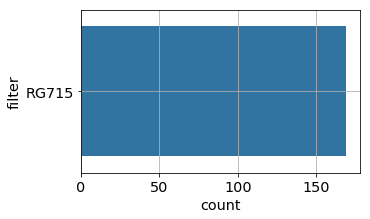

In [208]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

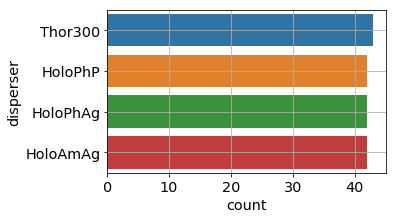

In [209]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [210]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [211]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [212]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [213]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [214]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Show the spectra

## Show the reconstructed spectra

In [215]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170610_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [216]:
#thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

In [217]:
#PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### Thor 300

In [218]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

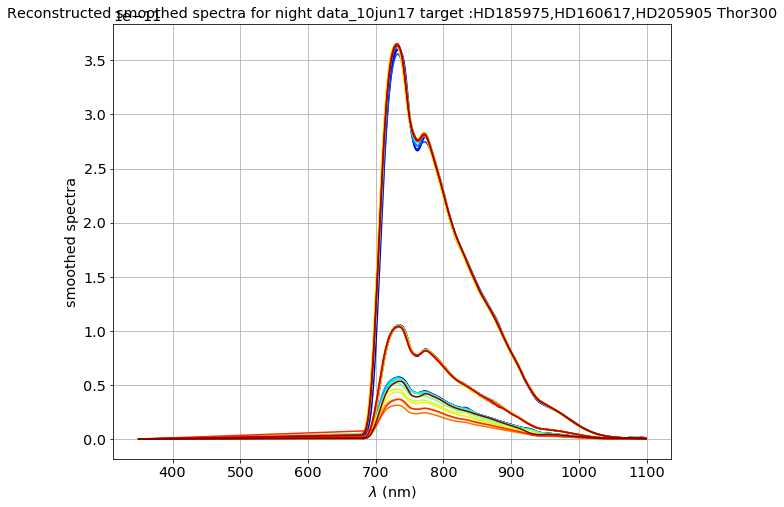

In [219]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhP

In [220]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

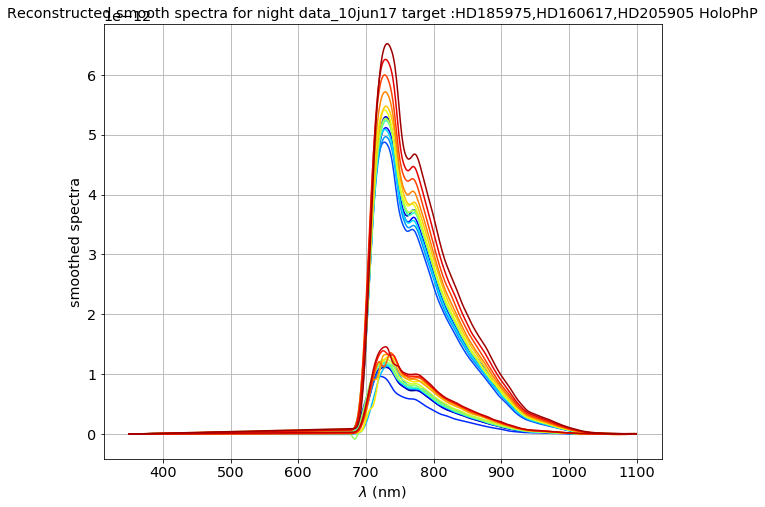

In [221]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhAg

In [222]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

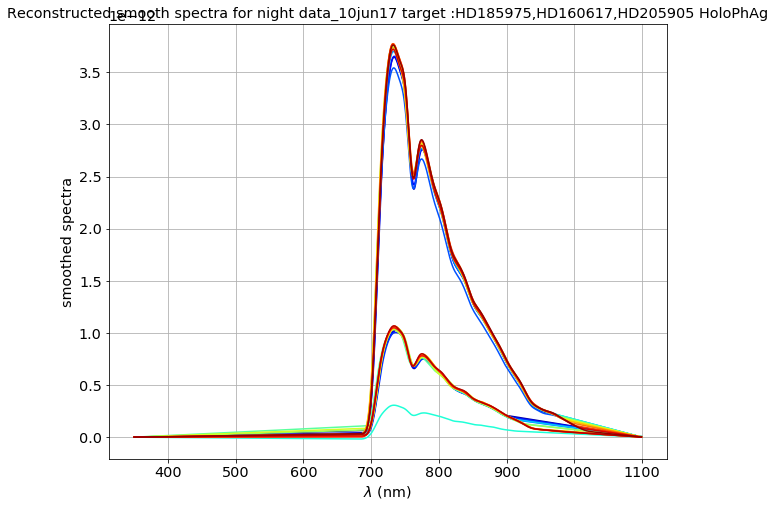

In [223]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloAmAg

In [224]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

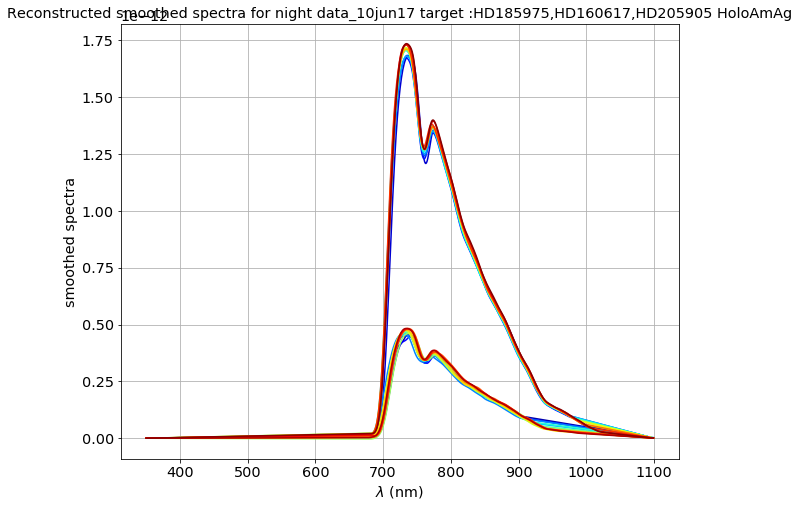

In [225]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## Show the simulated spectra

In [226]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [227]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

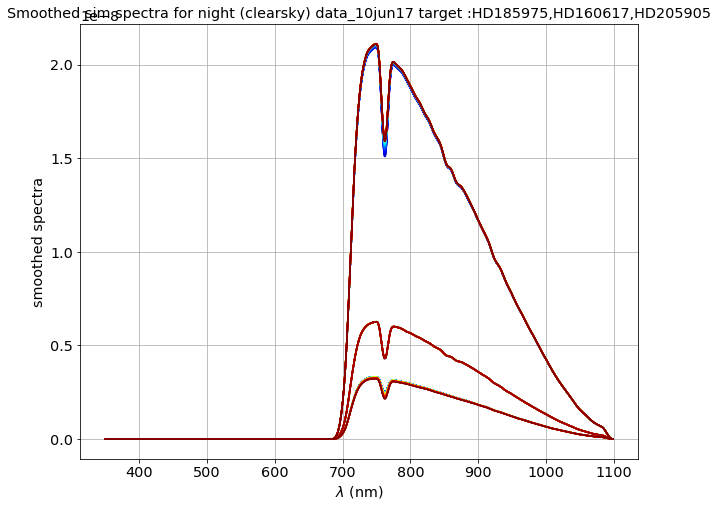

In [228]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### standard sky

In [229]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

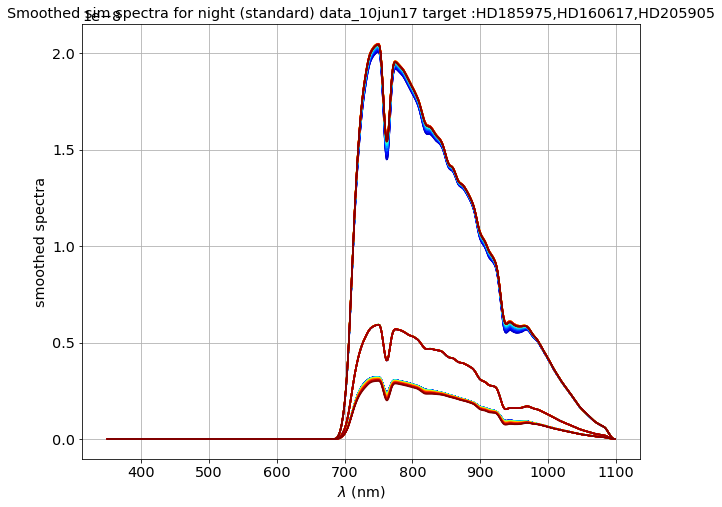

In [230]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### merra2 sky

In [231]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

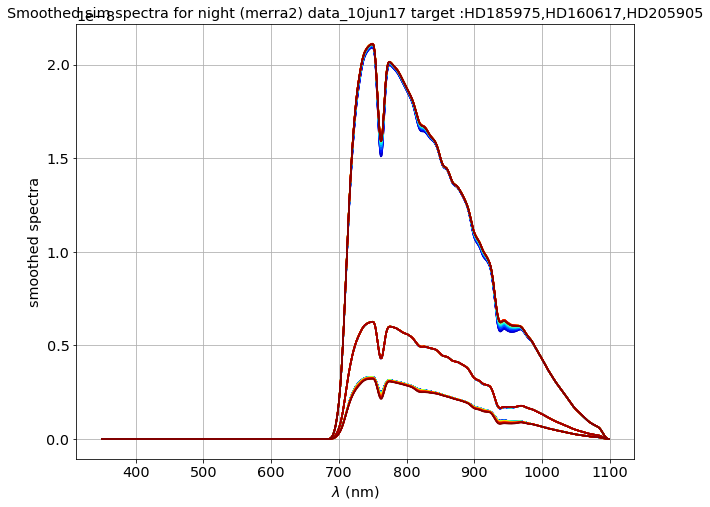

In [232]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

# Spectra ratio data/sim

In [233]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

## spectra ratio for Ronchi 400

In [234]:
#thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

In [235]:
#PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,
#                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [236]:
#PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,
#                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0)

In [237]:
#the_ratio_file="ratiosmooth_Ron400.fits"
#arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

In [238]:
#plt.imshow(arr[1:,:],cmap='jet')

## spectra ratio for Thor300

In [239]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

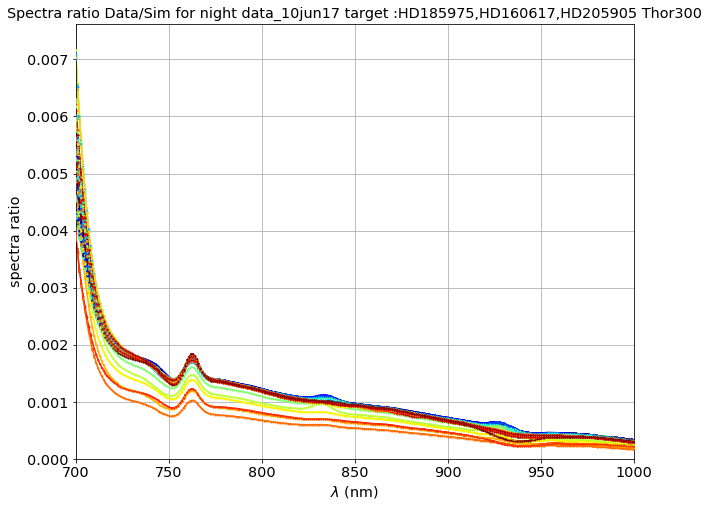

In [240]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=700,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 0.000101358894944 0.0152449418514


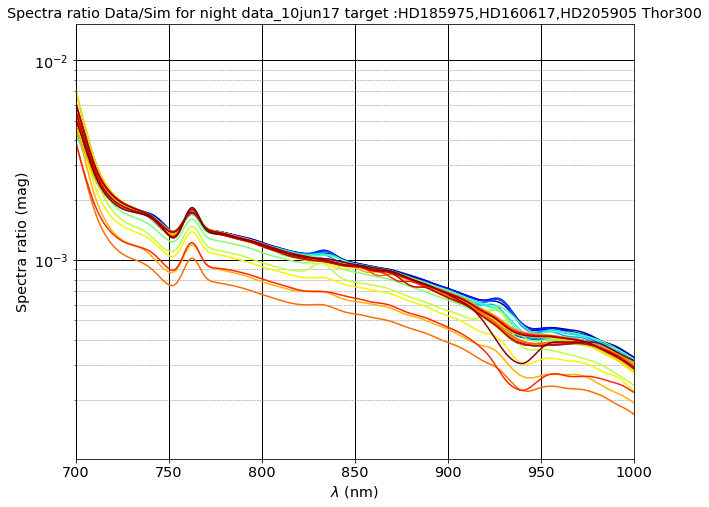

In [241]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=700,XMAX=1000.,YMIN=0,YMAX=0)

In [242]:
the_ratio_file="ratiosmooth_Thor300.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## spectra ratio for HoloPhP

In [243]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

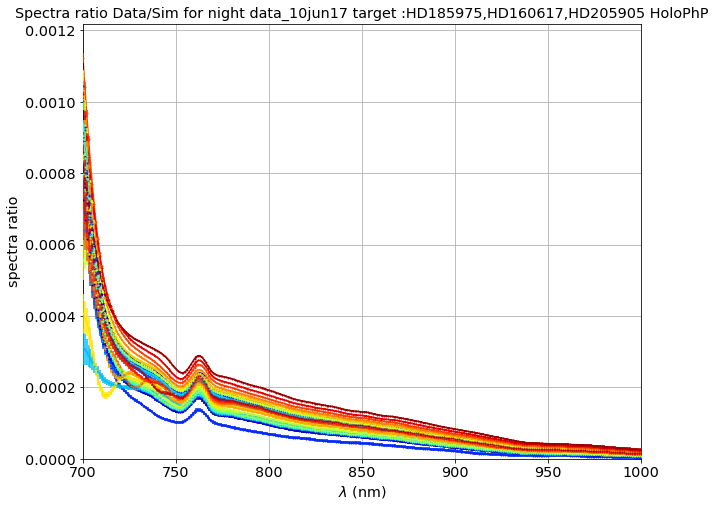

In [244]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=700,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 8.49912635527e-06 0.0024357695401


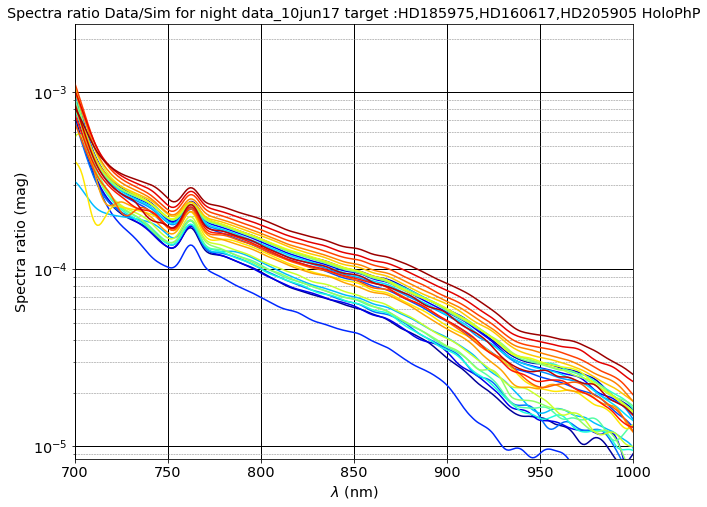

In [245]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=700,XMAX=1000.,YMIN=0,YMAX=0)

In [246]:
the_ratio_file="ratiosmooth_HoloPhP.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## Spectrum ratio for HoloPhAg

In [247]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

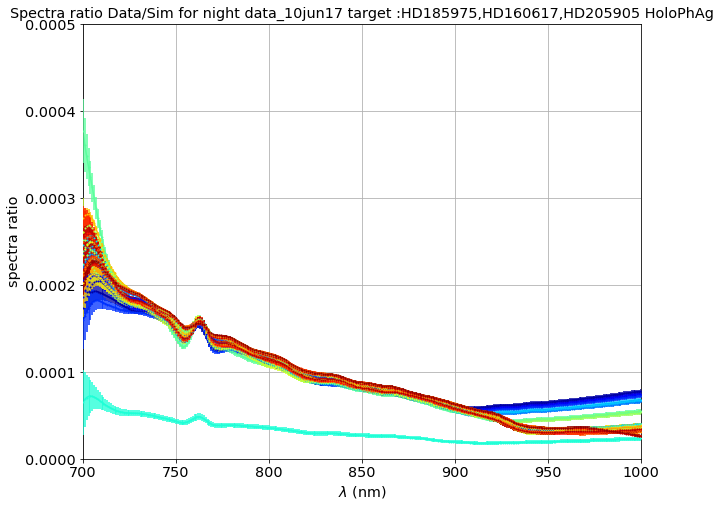

In [248]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=700,XMAX=1000.,YMIN=0,YMAX=0.0005)

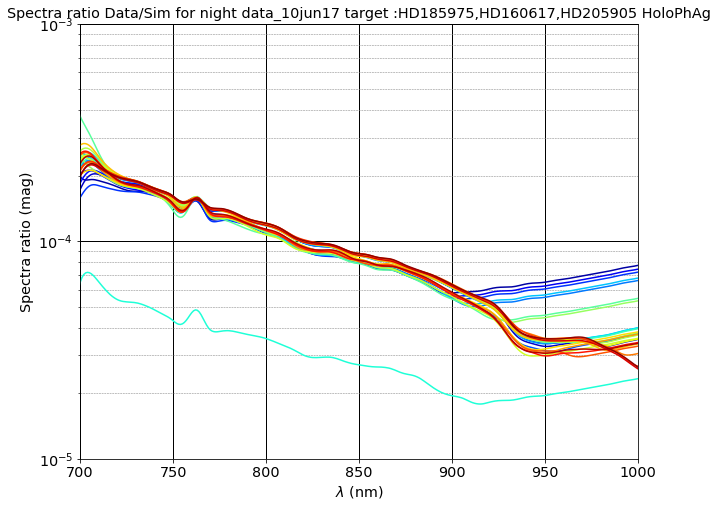

In [249]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=700,XMAX=1000.,YMIN=1e-5,YMAX=1e-3)

In [250]:
the_ratio_file="ratiosmooth_HoloPhAg.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhAg,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)              

## Spectrum ratio for HoloAmAg

In [251]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

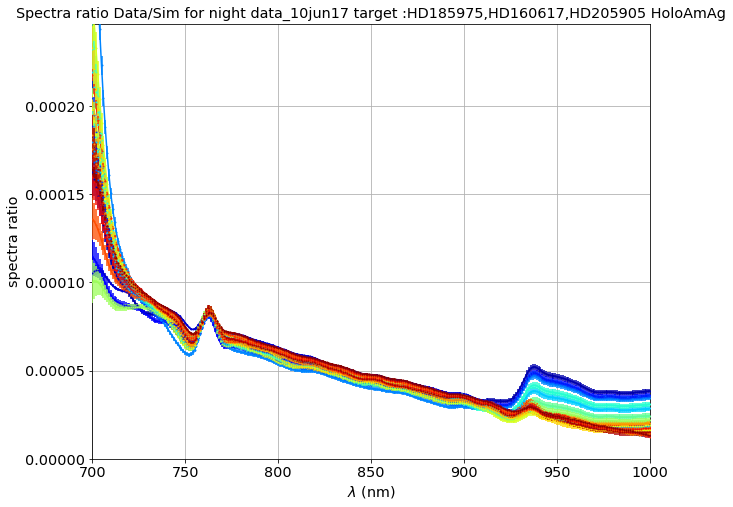

In [252]:
PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim2,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=700,XMAX=1000.,YMIN=0,YMAX=0)

the_Y_min,the_Y_max = 4.3785357289e-06 0.000476460570425


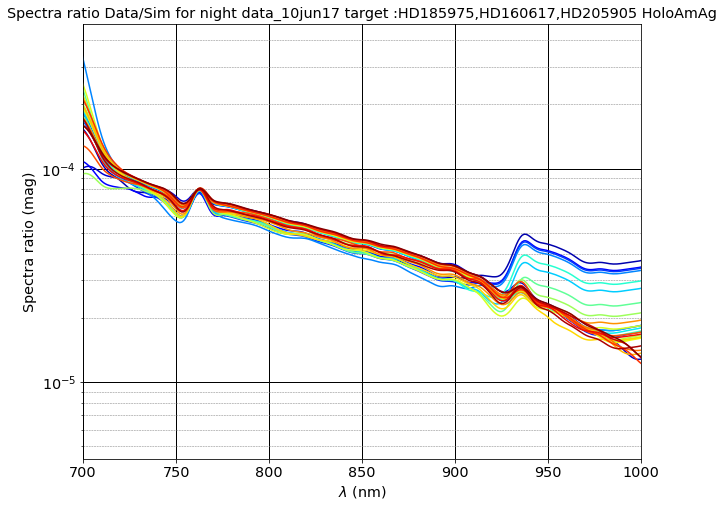

In [253]:
PlotSpectraLogRatioDataDivSimSmooth(all_spectrafiles,path_sim3,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,
                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=700,XMAX=1000.,YMIN=0,YMAX=0)

In [254]:
the_ratio_file="ratiosmooth_HoloAmAg.fits"
arr=SaveSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloAmAg,SearchTagRe,wlshift,the_ratio_file,FLAG_WL_CORRECTION,Flag_corr_wl=True)    